In [84]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

keepdim=True  
    指定保持在原始张量的轴数，而不折叠求和的维度

In [85]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
**)

In [86]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [87]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2515, 0.1027, 0.1953, 0.0819, 0.3687],
         [0.4144, 0.1653, 0.1147, 0.0591, 0.2466]]),
 tensor([1., 1.]))

## 定义模型  
使用`reshape`函数将每张原始图像展平为向量。  
-1为模糊控制的意思 就是批量大小  
W.shape[0]就是784  
b在这表示偏移量  
X和W进行矩阵乘法

In [88]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 定义损失函数

接下来，我们实现 :numref:`sec_softmax`中引入的交叉熵损失函数。

下面，我们[**创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，
以及它们对应的标签`y`。**]

有了`y`，我们知道在第一个样本中，第一类是正确的预测；
而在第二个样本中，第三类是正确的预测。
然后(**使用`y`作为`y_hat`中概率的索引**)，
我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。


选择y_hat中的元素 00 22 11  
00 12

In [89]:
# y = torch.tensor([0, 2, 1])
# y_hat = torch.tensor([[0.1, 0.2, 0.7],[0.4, 0.5, 0.1],[0.3, 0.3, 0.4]])
# y_hat[[0,2,1], y]

y = torch.tensor([0, 1])
y_hat = torch.tensor([[0.6, 0.3, 0.1], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.6000, 0.2000])

In [90]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([0.5108, 1.6094])

## 分类精度
使用`argmax`获得每行中最大元素的索引来获得预测类别。  
**将预测类别与真实`y`元素进行比较**   cmp bool类型 


In [93]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

"""样本的分类精度率"""
accuracy(y_hat, y) / len(y)


0.5

[**我们可以评估在任意模型`net`的精度**]   
对于任意数据迭代器`data_iter`可访问的数据集，


`isinstance()`可以判断一个变量的类型
由`torch.nn`实现的模型转成评估模式  
`.numel` :return the total number of elements in the tensor


In [94]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    """精度: 分类正确的样本数/总样本数"""
    return metric[0] / metric[1]

实用程序类`Accumulator`

In [95]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [96]:
evaluate_accuracy(net, test_iter)

0.1002

## softmax训练

In [97]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)

    for X, y in train_iter:
        # 计算梯度 更行参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # PyTorch内置的优化器和损失函数
            updater.zero_grad()     # .zero_grad()将模型的参数梯度初始化为0
            l.mean().backward()     # .mean()求取均值 .backward()计算导数
            updater.step()          # .step()更新所有参数
        
        else:
            # 定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())   #这一段还需理解

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


**定义一个在动画中绘制数据的实用程序类**]`Animator`

In [98]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

实现一个[**训练函数**]  
它会在`train_iter`访问到的训练数据集上训练一个模型`net`。  
该训练函数将会运行多个迭代周期（由`num_epochs`指定）。  
在每个迭代周期结束时，利用`test_iter`访问到的测试数据集对模型进行评估。  
我们将利用`Animator`类来可视化训练进度。  

In [99]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

从零开始的实现  
**小批量随机梯度下降来优化模型的损失函数**设置学习率lr为0.1,  
**训练模型10个迭代周期**

请注意，迭代周期（`num_epochs`）和学习率（`lr`）都是可调节的超参数。
通过更改它们的值，我们可以提高模型的分类精度。

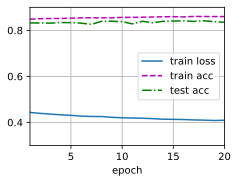

In [101]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 20
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)